In [ ]:
from datetime import datetime, timedelta

import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pandas as pd
import pystac_client
import rioxarray  # noqa: F401
import shap
import xarray as xr
from dask.distributed import Client
from odc.geo.geobox import GeoBox
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    StratifiedGroupKFold,
    StratifiedKFold,
    cross_val_score,
)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler

client = Client(processes=False)

# Week 6: Multi-Class Land Cover Classification and Model Generalization

This lab extends last week's binary forest classification to a six-class problem: water, wetland, urban/built-up, cropland, grassland, and forest/shrubland. We'll think critically about sampling, feature engineering, evaluation metrics, feature importance, and generalizability.

## Part 1: Data Acquisition, Preprocessing, and Feature Engineering

### 1.1 Load Sentinel-2 Imagery for Vienna (March 2020)

In [24]:
# Load all available Sentinel-2 bands for initial analysis
ALL_BANDS = [
    "scl",
    "red",
    "green",
    "blue",
    "nir",
    "swir16",
    "swir22",
    "rededge1",
    "rededge2",
    "rededge3",
]
dx = 0.0006  # ~60m resolution
epsg = 4326

vienna_bounds = (16.32, 47.86, 16.9, 48.407)

start_date = datetime(year=2020, month=3, day=1)
end_date = start_date + timedelta(days=30)
date_query = f"{start_date.strftime('%Y-%m-%d')}/{end_date.strftime('%Y-%m-%d')}"

stac_client = pystac_client.Client.open("https://earth-search.aws.element84.com/v1")

vienna_items = stac_client.search(
    bbox=vienna_bounds,
    collections=["sentinel-2-l2a"],
    datetime=date_query,
    query={"eo:cloud_cover": {"lt": 50}},
    limit=100,
).item_collection()

print(f"Vienna: {len(vienna_items)} scenes found")

vienna_geobox = GeoBox.from_bbox(vienna_bounds, crs=f"epsg:{epsg}", resolution=dx)

dc_vienna = odc.stac.load(
    vienna_items,
    bands=ALL_BANDS,
    chunks={"time": 5, "x": 600, "y": 600},
    geobox=vienna_geobox,
    resampling="bilinear",
)
dc_vienna

Vienna: 19 scenes found


<xarray.Dataset> Size: 285MB
Dimensions:      (latitude: 913, longitude: 967, time: 17)
Coordinates:
  * latitude     (latitude) float64 7kB 48.41 48.41 48.41 ... 47.86 47.86 47.86
  * longitude    (longitude) float64 8kB 16.32 16.32 16.32 ... 16.9 16.9 16.9
  * time         (time) datetime64[ns] 136B 2020-03-08T09:57:16.896000 ... 20...
    spatial_ref  int32 4B 4326
Data variables:
    scl          (time, latitude, longitude) uint8 15MB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>
    red          (time, latitude, longitude) uint16 30MB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>
    green        (time, latitude, longitude) uint16 30MB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>
    blue         (time, latitude, longitude) uint16 30MB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>
    nir          (time, latitude, longitude) uint16 30MB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>
    swir16       (time, latitude, longitude) uint16 30MB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>
    swir22       (time, latitude, longitude) uint16 30MB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>
    rededge1     (time, latitude, longitude) uint16 30MB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>
    rededge2     (time, latitude, longitude) uint16 30MB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>
    rededge3     (time, latitude, longitude) uint16 30MB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>

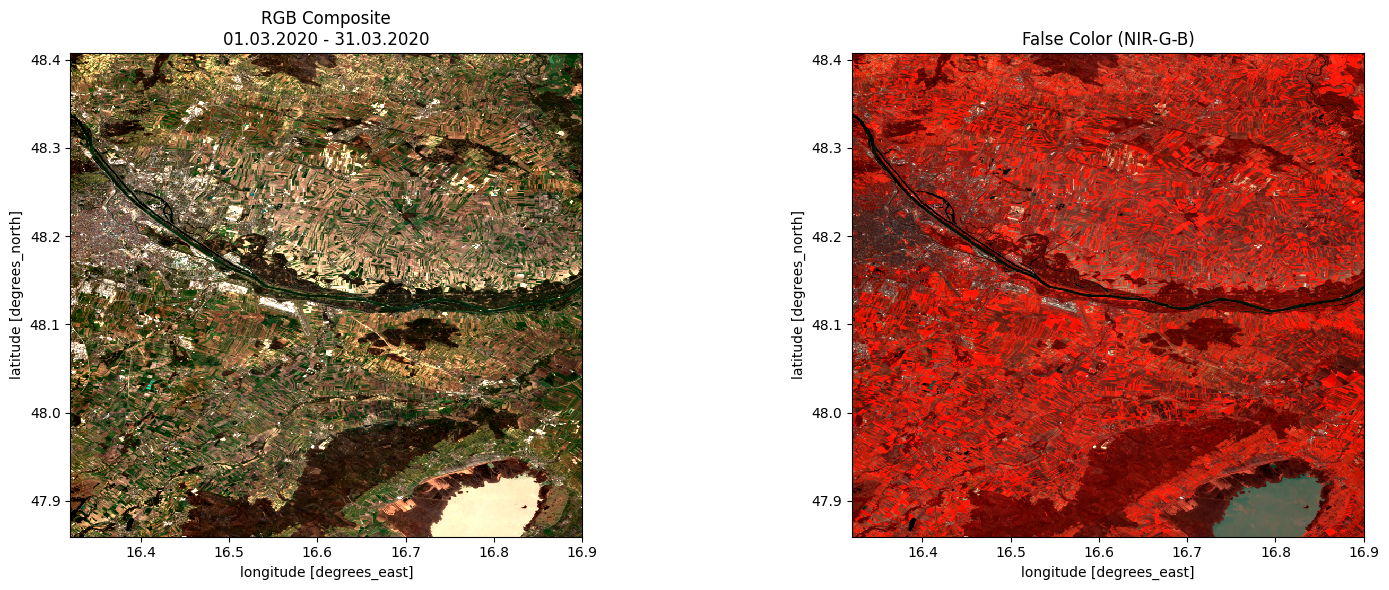

In [25]:
def is_valid_pixel(data):
    """Include vegetated, not_vegetated, water, and snow pixels (SCL classes 4-6 and 11)."""
    return ((data > 3) & (data < 7)) | (data == 11)


valid_mask = is_valid_pixel(dc_vienna.scl)
dc_valid = dc_vienna.where(valid_mask)

all_median = (
    dc_valid[["red", "green", "blue", "nir"]]
    .to_dataarray(dim="band")
    .median(dim="time")
    .compute()
)

rgb_median = all_median.sel(band=["red", "green", "blue"])
fc_median = all_median.sel(band=["nir", "green", "blue"])

fig1, axes1 = plt.subplots(1, 2, figsize=(16, 6))
rgb_median.plot.imshow(ax=axes1[0], robust=True)
axes1[0].set_title(
    f"RGB Composite\n{start_date.strftime('%d.%m.%Y')} - {end_date.strftime('%d.%m.%Y')}"
)
axes1[0].set_aspect("equal")

fc_median.plot.imshow(ax=axes1[1], robust=True)
axes1[1].set_title("False Color (NIR-G-B)")
axes1[1].set_aspect("equal")

plt.tight_layout()

### 1.2 Load Training Data

The training data comes from OSMlanduse, a contiguous land use map of the EU derived from OpenStreetMap and Sentinel-2, current as of March 2020.

In [26]:
gdf_samples = gpd.read_parquet("vienna_samples.parquet")

class_counts = gdf_samples["class_name"].value_counts()
class_pcts = (class_counts / len(gdf_samples) * 100).round(1)
class_dist = pd.DataFrame({"Count": class_counts, "Percent": class_pcts})

print(f"Total samples: {len(gdf_samples)}\n")
print("Samples per class:")
print(class_dist.to_string())

Total samples: 10000

Samples per class:
                  Count  Percent
class_name                      
Cropland           5438     54.4
Forest / shrub     1853     18.5
Urban / built-up   1496     15.0
Grassland           538      5.4
Water               414      4.1
Wetland             261      2.6


The dataset has 10,000 samples with substantial class imbalance. Cropland dominates (5,438 samples, ~54%), while wetland (261) and water (414) are underrepresented. This imbalance means we should use stratified sampling to preserve class proportions, balanced class weights in the classifier, and evaluation metrics like macro-averaged accuracy that weight all classes equally regardless of sample size.

### 1.3 Feature Correlation Analysis

Before selecting features, we examine correlations across all available Sentinel-2 bands to identify redundancy.

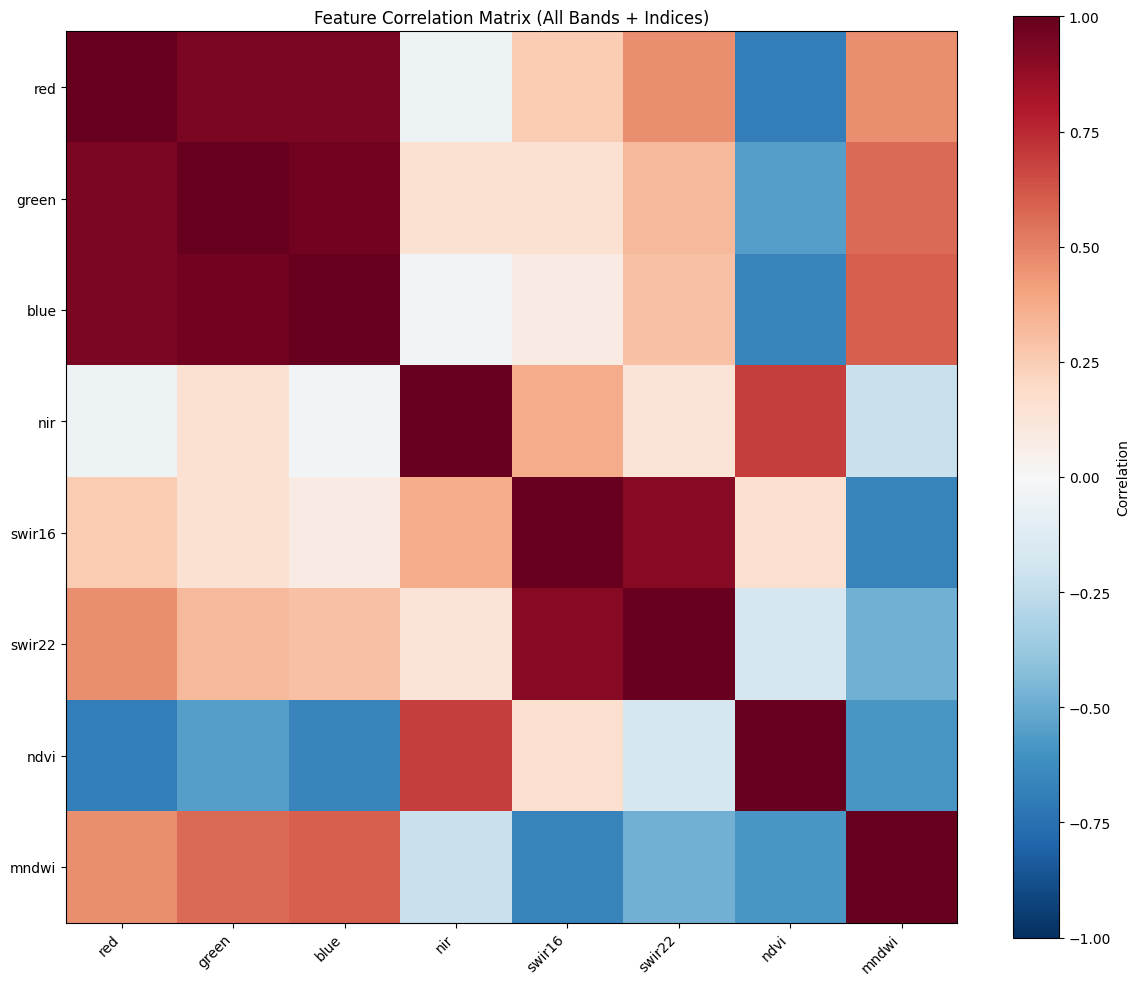

In [63]:
# All spectral bands (excluding SCL) for correlation analysis
ALL_FEATURE_BANDS = ["red", "green", "blue", "nir", "swir16", "swir22"]

# Compute median for all bands
all_bands_median = dc_valid[ALL_FEATURE_BANDS].median(dim="time").compute()

# Compute spectral indices
ndvi = (all_bands_median["nir"] - all_bands_median["red"]) / (
    all_bands_median["nir"] + all_bands_median["red"]
)
mndwi = (all_bands_median["green"] - all_bands_median["swir16"]) / (
    all_bands_median["green"] + all_bands_median["swir16"]
)

# Add indices to the dataset
all_bands_median["ndvi"] = ndvi
all_bands_median["mndwi"] = mndwi

# Full feature list including indices
ALL_FEATURES = ALL_FEATURE_BANDS + ["ndvi", "mndwi"]

# Extract all features at sample locations
X_all_bands = np.column_stack(
    [
        all_bands_median[f]
        .sel(
            longitude=xr.DataArray(gdf_samples.geometry.x.values, dims="points"),
            latitude=xr.DataArray(gdf_samples.geometry.y.values, dims="points"),
            method="nearest",
        )
        .values
        for f in ALL_FEATURES
    ]
)
y_all_raw = gdf_samples["class_id"].values

# Drop NaN samples
valid_samples_mask = ~np.isnan(X_all_bands).any(axis=1)
X_all_bands_clean = X_all_bands[valid_samples_mask]

# Correlation matrix
corr_matrix_full = np.corrcoef(X_all_bands_clean.T)
corr_df = pd.DataFrame(corr_matrix_full, index=ALL_FEATURES, columns=ALL_FEATURES)

# Plot heatmap
fig_corr_full, ax_corr_full = plt.subplots(figsize=(12, 10))
im_full = ax_corr_full.imshow(corr_matrix_full, cmap="RdBu_r", vmin=-1, vmax=1)
ax_corr_full.set_xticks(range(len(ALL_FEATURES)))
ax_corr_full.set_yticks(range(len(ALL_FEATURES)))
ax_corr_full.set_xticklabels(ALL_FEATURES, rotation=45, ha="right")
ax_corr_full.set_yticklabels(ALL_FEATURES)
plt.colorbar(im_full, ax=ax_corr_full, label="Correlation")
ax_corr_full.set_title("Feature Correlation Matrix (All Bands + Indices)")
plt.tight_layout()

### 1.4 Feature Selection

The correlation analysis shows a lot of redundancy across features. However, I played around with different feature sets and found that basically just throwing everything into the model (indices included) produced the best results. This is not well-grounded empirically, but Random Forest models are generally robust to multicollinearity, and the extra features may get at subtle differences that improve class separation. For even better performance, we could consider things like improving resolution (e.g., using the native 10m resolution instead of the 60m resolution we're using here for speed) or engineering time series features.

In [64]:
# Selected features based on correlation analysis
FEATURE_BANDS = ["red", "green", "blue", "nir", "swir16", "swir22", "ndvi", "mndwi"]

# Extract only selected features
ds_features = all_bands_median[FEATURE_BANDS]
feature_names = FEATURE_BANDS

X_all = np.column_stack(
    [
        ds_features[f]
        .sel(
            longitude=xr.DataArray(gdf_samples.geometry.x.values, dims="points"),
            latitude=xr.DataArray(gdf_samples.geometry.y.values, dims="points"),
            method="nearest",
        )
        .values
        for f in feature_names
    ]
)[valid_samples_mask]

y_all = y_all_raw[valid_samples_mask]

## Part 2: Multi-Class Classification and Evaluation

### 2.1 Sample Size Comparison

We compare Random Forest models trained on 100, 1,000, 5,000, and all 10,000 samples using a 70/30 split.

In [65]:
sample_sizes = [100, 1_000, 5_000, 10_000]
results = []

for n in sample_sizes:
    if n < len(X_all):
        X_sub, _, y_sub, _ = train_test_split(
            X_all, y_all, train_size=n, random_state=42, stratify=y_all
        )
    else:
        X_sub, y_sub = X_all, y_all

    X_train, X_test, y_train, y_test = train_test_split(
        X_sub, y_sub, test_size=0.3, random_state=42, stratify=y_sub
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    rf = RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1,
    )
    rf.fit(X_train_scaled, y_train)
    y_pred = rf.predict(X_test_scaled)

    results.append(
        {
            "Samples": n,
            "Overall Acc.": accuracy_score(y_test, y_pred),
            "Macro Acc.": balanced_accuracy_score(y_test, y_pred),
            "Macro Prec.": precision_score(y_test, y_pred, average="macro"),
            "Macro Recall": recall_score(y_test, y_pred, average="macro"),
        }
    )

results_df = pd.DataFrame(results).set_index("Samples")
print(results_df.round(3).to_string())

         Overall Acc.  Macro Acc.  Macro Prec.  Macro Recall
Samples                                                     
100             0.633       0.273        0.264         0.273
1000            0.733       0.522        0.662         0.522
5000            0.793       0.635        0.813         0.635
10000           0.808       0.655        0.756         0.655


Performance improves substantially from 100 to 1,000 samples (macro accuracy jumps from ~27% to ~52%), with continued gains through 5,000 and 10,000 samples. The gap between overall accuracy (~81%) and macro accuracy (~66%) at 10,000 samples reflects class imbalance: the model performs well on majority classes like cropland but struggles with minority classes like grassland (only 538 samples).

### 2.2 Validation Strategy Comparison

We compare three validation approaches using macro-averaged accuracy: random 70/30 split, 5-fold stratified CV, and 5-fold spatial CV using grid-based grouping.

Validation Strategy Comparison (Macro-Averaged Accuracy)
Random 70/30 split:    0.6547
5-fold Stratified CV:  0.6468 ± 0.0126
5-fold Spatial CV:     0.6320 ± 0.0314


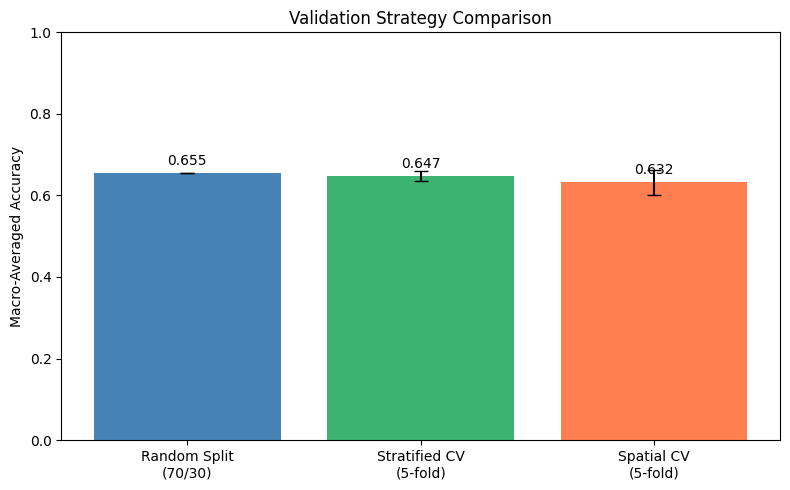

In [ ]:
# Random 70/30 split
X_tr, X_te, y_tr, y_te = tts(
    X_all, y_all, test_size=0.3, random_state=42, stratify=y_all
)
sc = StandardScaler()
rf_split = RandomForestClassifier(
    n_estimators=100, class_weight="balanced", random_state=42, n_jobs=-1
)
rf_split.fit(sc.fit_transform(X_tr), y_tr)
acc_split = balanced_accuracy_score(y_te, rf_split.predict(sc.transform(X_te)))

# 5-fold stratified CV
cv_scores = cross_val_score(
    RandomForestClassifier(
        n_estimators=100, class_weight="balanced", random_state=42, n_jobs=-1
    ),
    StandardScaler().fit_transform(X_all),
    y_all,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="balanced_accuracy",
)

# 5-fold spatial CV
grid_size = 0.05  # ~5km cells
sample_x = gdf_samples.geometry.x.values[valid_samples_mask]
sample_y = gdf_samples.geometry.y.values[valid_samples_mask]
spatial_groups = (sample_x // grid_size).astype(int) * 10000 + (
    sample_y // grid_size
).astype(int)

sgkf = StratifiedGroupKFold(n_splits=5)
spatial_cv_scores = []

for train_idx, test_idx in sgkf.split(X_all, y_all, spatial_groups):
    scaler_cv = StandardScaler()
    X_train_cv = scaler_cv.fit_transform(X_all[train_idx])
    X_test_cv = scaler_cv.transform(X_all[test_idx])

    rf_cv = RandomForestClassifier(
        n_estimators=100, class_weight="balanced", random_state=42, n_jobs=-1
    )
    rf_cv.fit(X_train_cv, y_all[train_idx])
    spatial_cv_scores.append(
        balanced_accuracy_score(y_all[test_idx], rf_cv.predict(X_test_cv))
    )

print("Validation Strategy Comparison (Macro-Averaged Accuracy)")
print("=" * 55)
print(f"Random 70/30 split:    {acc_split:.4f}")
print(f"5-fold Stratified CV:  {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
print(
    f"5-fold Spatial CV:     {np.mean(spatial_cv_scores):.4f} ± {np.std(spatial_cv_scores):.4f}"
)

fig_cv, ax_cv = plt.subplots(figsize=(8, 5))
labels_cv = ["Random Split\n(70/30)", "Stratified CV\n(5-fold)", "Spatial CV\n(5-fold)"]
values_cv = [acc_split, np.mean(cv_scores), np.mean(spatial_cv_scores)]
errors_cv = [0, np.std(cv_scores), np.std(spatial_cv_scores)]
bars = ax_cv.bar(
    labels_cv,
    values_cv,
    yerr=errors_cv,
    capsize=5,
    color=["steelblue", "mediumseagreen", "coral"],
)
ax_cv.set_ylabel("Macro-Averaged Accuracy")
ax_cv.set_title("Validation Strategy Comparison")
ax_cv.set_ylim(0, 1)
for bar, val in zip(bars, values_cv):
    ax_cv.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,
        f"{val:.3f}",
        ha="center",
    )
plt.tight_layout()

All three methods produce similar macro-averaged accuracy, with spatial CV showing slightly higher variance. The small difference between random and spatial CV suggests that spatial autocorrelation is not a major issue in this dataset (perhaps because I generated it by randomly sampling points as opposed to manually drawing polygons), likely because land cover classes are distributed relatively evenly across the study area. In landscapes with more spatial clustering, we would expect a larger gap.

### 2.3 Detailed Evaluation with Spatial CV

We report full metrics from the spatial cross-validation: per-class precision and recall, and a confusion matrix.

Classification Report (Spatial CV)
              precision    recall  f1-score   support

       Water       0.87      0.84      0.85       414
     Wetland       0.91      0.56      0.69       261
       Urban       0.70      0.68      0.69      1496
    Cropland       0.82      0.94      0.87      5438
   Grassland       0.40      0.10      0.16       538
      Forest       0.79      0.69      0.74      1853

    accuracy                           0.79     10000
   macro avg       0.75      0.63      0.67     10000
weighted avg       0.78      0.79      0.78     10000



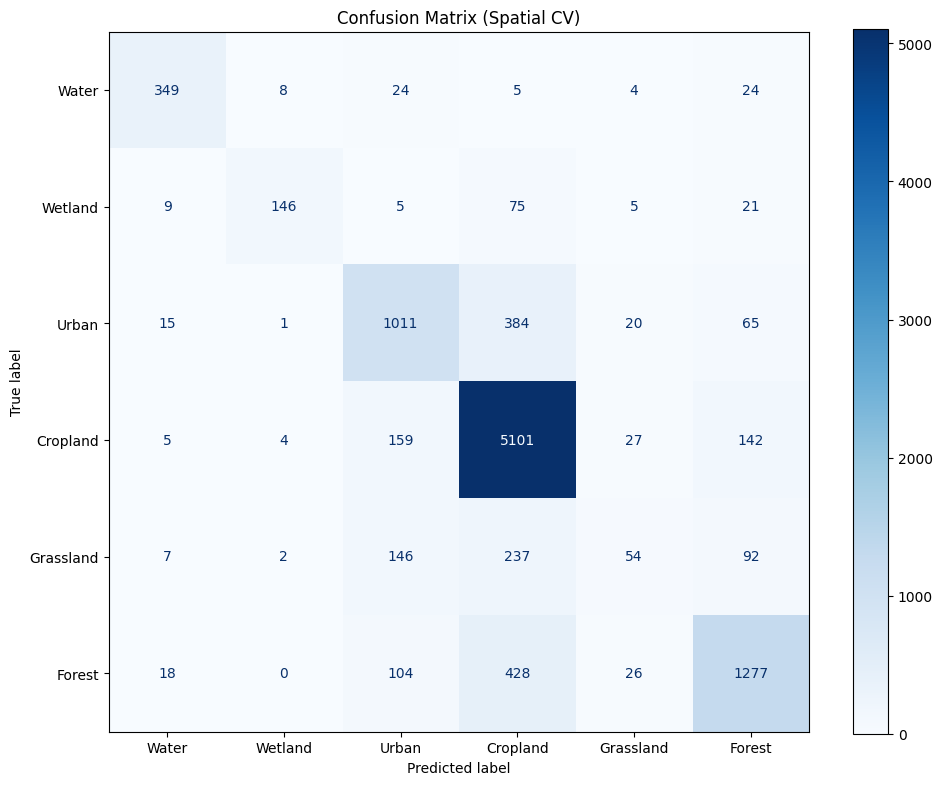

In [67]:
# Collect predictions from all folds
y_true_all = []
y_pred_all = []

sgkf2 = StratifiedGroupKFold(n_splits=5)
for train_idx2, test_idx2 in sgkf2.split(X_all, y_all, spatial_groups):
    scaler2 = StandardScaler()
    X_train2 = scaler2.fit_transform(X_all[train_idx2])
    X_test2 = scaler2.transform(X_all[test_idx2])

    rf2 = RandomForestClassifier(
        n_estimators=100, class_weight="balanced", random_state=42, n_jobs=-1
    )
    rf2.fit(X_train2, y_all[train_idx2])

    y_true_all.extend(y_all[test_idx2])
    y_pred_all.extend(rf2.predict(X_test2))

y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

class_names = ["Water", "Wetland", "Urban", "Cropland", "Grassland", "Forest"]
print("Classification Report (Spatial CV)")
print("=" * 60)
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

fig_cm, ax_cm = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_true_all, y_pred_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax_cm, cmap="Blues", values_format="d")
ax_cm.set_title("Confusion Matrix (Spatial CV)")
plt.tight_layout()

The confusion matrix reveals clear patterns. Cropland achieves the highest recall (94%) due to its large sample size and distinct agricultural spectral signature. Water performs well (84% recall) despite few samples because of its unique spectral properties. Grassland is the hardest class to classify (10% recall), with most samples misclassified as cropland or forest. This makes sense: grassland in early spring (March) is spectrally similar to bare agricultural fields and early-stage forest understory. Wetland shows moderate performance (54% recall), with confusion primarily against water and grassland.

### 2.4 Predicted Map

We apply the model to the full Vienna scene and compare the prediction to the RGB image.

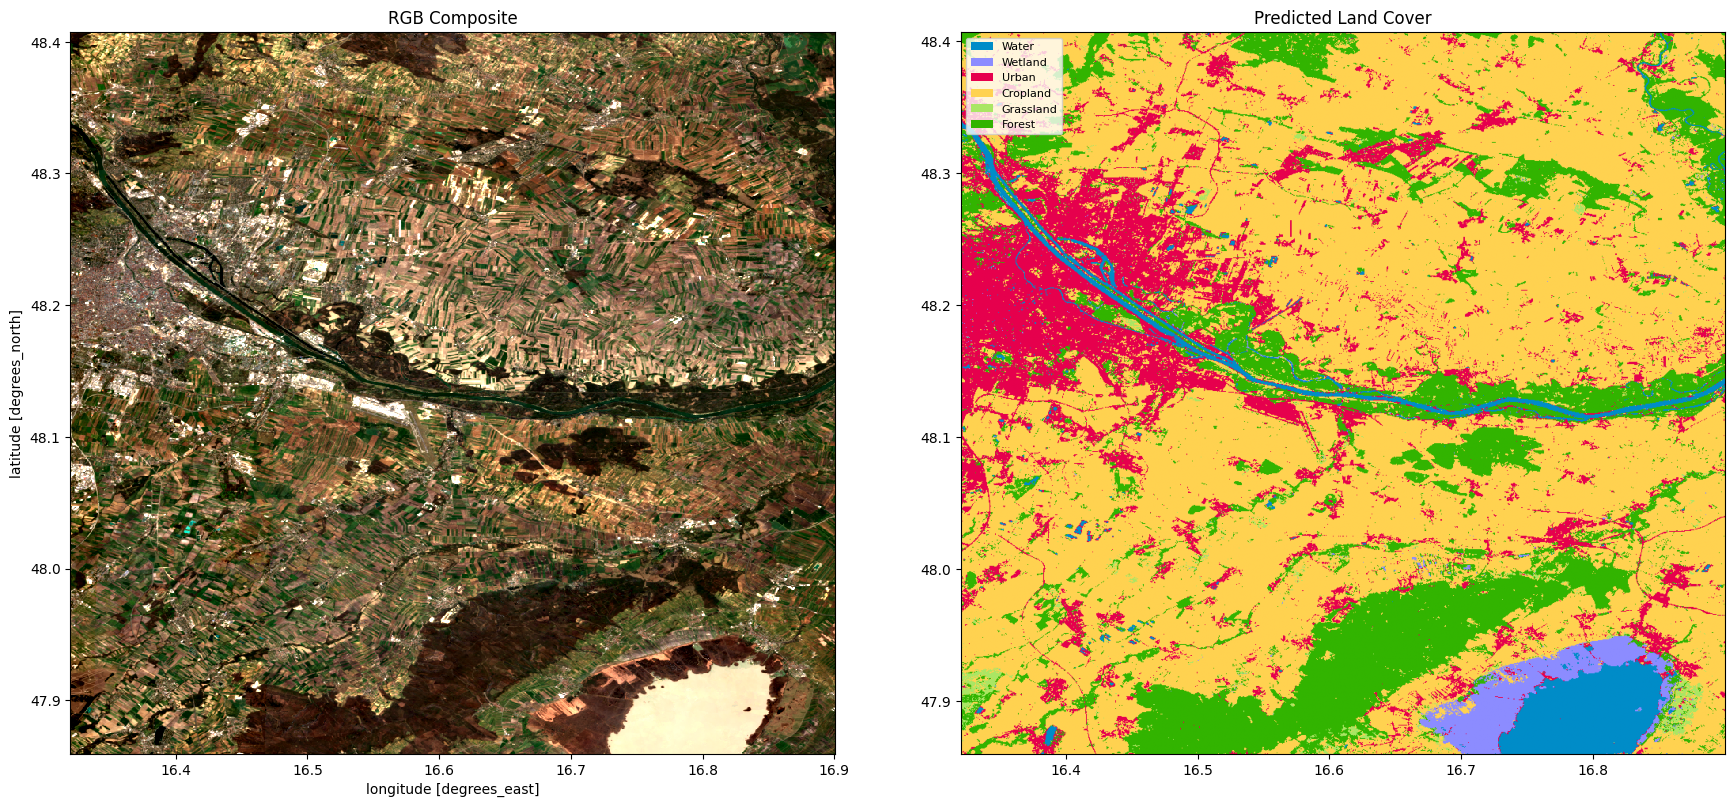

In [68]:
# Define colormap
new_classes = {
    1: ("Water", (0, 140, 200)),
    2: ("Wetland", (140, 140, 255)),
    3: ("Urban", (230, 0, 77)),
    4: ("Cropland", (255, 210, 80)),
    5: ("Grassland", (170, 230, 100)),
    6: ("Forest", (50, 180, 0)),
}

class_ids = list(new_classes.keys())
colors = [np.array(rgb) / 255 for _, rgb in new_classes.values()]
labels = [name for name, _ in new_classes.values()]
cmap = mcolors.ListedColormap(colors)
bounds = class_ids + [class_ids[-1] + 1]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Train final model on all data
scaler_final = StandardScaler()
X_all_scaled = scaler_final.fit_transform(X_all)
rf_final = RandomForestClassifier(
    n_estimators=100, class_weight="balanced", random_state=42, n_jobs=-1
)
rf_final.fit(X_all_scaled, y_all)

# Predict on full image
ds_features_full = all_bands_median[FEATURE_BANDS]
image_data = ds_features_full.to_array(dim="band").transpose(
    "latitude", "longitude", "band"
)
img_shape = (all_bands_median.sizes["latitude"], all_bands_median.sizes["longitude"])
X_image = image_data.values.reshape(-1, len(FEATURE_BANDS))

nan_mask_img = np.isnan(X_image).any(axis=1)
X_image_clean = np.nan_to_num(X_image)
X_image_scaled = scaler_final.transform(X_image_clean)

y_pred_img = rf_final.predict(X_image_scaled).reshape(img_shape).astype(float)
y_pred_img[nan_mask_img.reshape(img_shape)] = np.nan

fig_pred, axes_pred = plt.subplots(1, 2, figsize=(18, 8))

rgb_median.plot.imshow(ax=axes_pred[0], robust=True)
axes_pred[0].set_title("RGB Composite")
axes_pred[0].set_aspect("equal")

axes_pred[1].imshow(
    y_pred_img,
    cmap=cmap,
    norm=norm,
    extent=[
        all_bands_median.longitude.min(),
        all_bands_median.longitude.max(),
        all_bands_median.latitude.min(),
        all_bands_median.latitude.max(),
    ],
)
axes_pred[1].set_title("Predicted Land Cover")
axes_pred[1].set_aspect("equal")

patches = [plt.Rectangle((0, 0), 1, 1, fc=c) for c in colors]
axes_pred[1].legend(patches, labels, loc="upper left", fontsize=8)
plt.tight_layout()

Visually, the results look quite reasonable. For further confidence, we could compare them to things like ESA WorldCover... or just check the original dataset I used to generate training labels. ;)

### 2.5 Feature Importance

We compare three methods: MDI (Mean Decrease in Impurity), permutation importance, and SHAP values. SWIR22 and MNDWI emerge as the most important features. SWIR22 captures moisture and built-up surface properties that other bands miss. MNDWI, despite being a simple ratio of green and swir16, provides normalized water detection that outperforms its component bands alone. The visible bands (especially red) and NDVI contribute least, suggesting that vegetation indices add little value when raw NIR and SWIR bands are already present

mean_abs_shap shape: (8,)


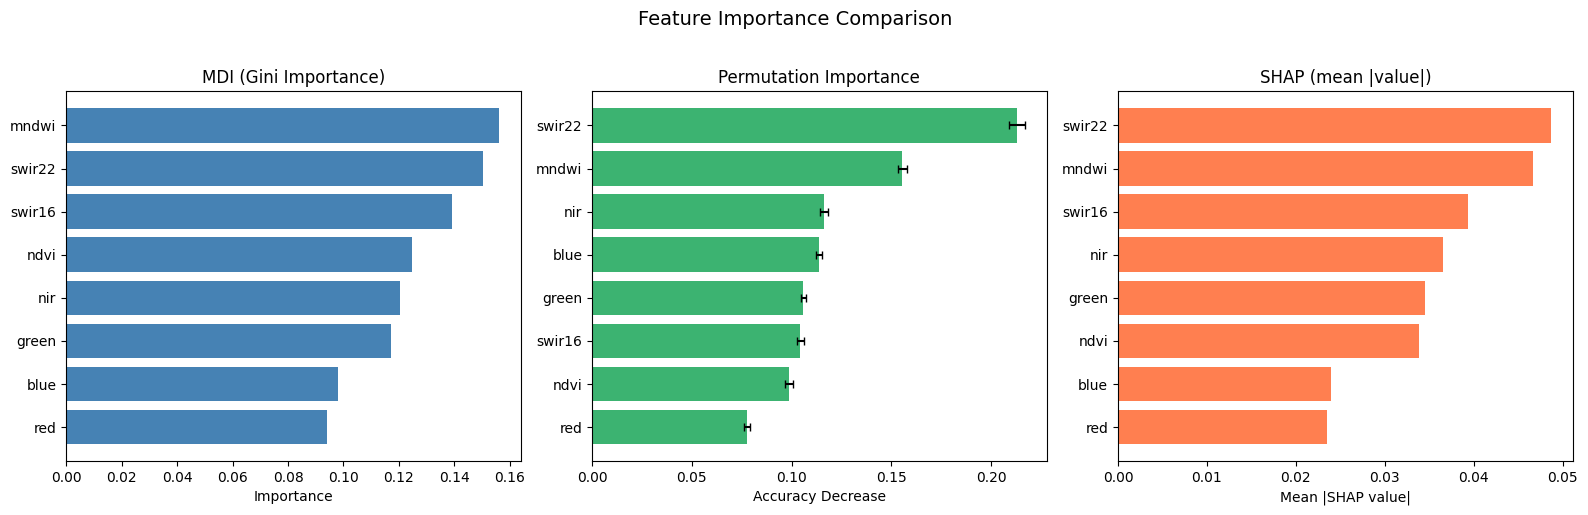

In [ ]:
fig_imp, axes_imp = plt.subplots(1, 3, figsize=(16, 5))

# MDI
mdi = rf_final.feature_importances_
sorted_idx_mdi = np.argsort(mdi)
axes_imp[0].barh(
    np.array(FEATURE_BANDS)[sorted_idx_mdi], mdi[sorted_idx_mdi], color="steelblue"
)
axes_imp[0].set_title("MDI (Gini Importance)")
axes_imp[0].set_xlabel("Importance")

# Permutation Importance
perm_result = permutation_importance(
    rf_final, X_all_scaled, y_all, n_repeats=10, random_state=42, n_jobs=-1
)
sorted_idx_perm = np.argsort(perm_result.importances_mean)
axes_imp[1].barh(
    np.array(FEATURE_BANDS)[sorted_idx_perm],
    perm_result.importances_mean[sorted_idx_perm],
    xerr=perm_result.importances_std[sorted_idx_perm],
    color="mediumseagreen",
    capsize=3,
)
axes_imp[1].set_title("Permutation Importance")
axes_imp[1].set_xlabel("Accuracy Decrease")

# SHAP
explainer = shap.TreeExplainer(rf_final)
shap_sample_idx = np.random.default_rng(42).choice(
    len(X_all_scaled), size=1000, replace=False
)
shap_values = explainer.shap_values(X_all_scaled[shap_sample_idx])

mean_abs_shap = np.abs(shap_values).mean(
    axis=(0, 2)
)  # average over samples and classes

sorted_idx_shap = np.argsort(mean_abs_shap)
axes_imp[2].barh(
    np.array(FEATURE_BANDS)[sorted_idx_shap],
    mean_abs_shap[sorted_idx_shap],
    color="coral",
)
axes_imp[2].set_title("SHAP (mean |value|)")
axes_imp[2].set_xlabel("Mean |SHAP value|")

plt.suptitle("Feature Importance Comparison", fontsize=14, y=1.02)
plt.tight_layout()

## Part 3: Generalization

Finally, we test whether the Vienna-trained model generalizes to Damascus, Syria, a region with different climate, vegetation, and land cover patterns.

Damascus: 38 scenes found


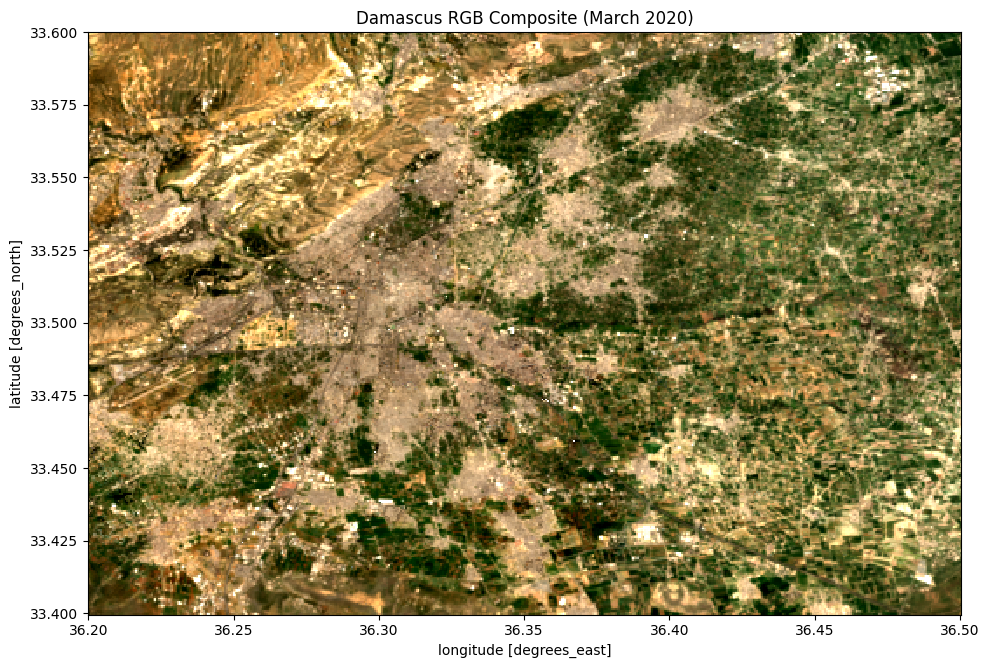

In [84]:
damascus_bounds = (36.2, 33.4, 36.5, 33.6)

# Load bands needed for prediction plus RGB for visualization

DAMASCUS_BANDS = ["scl", "red", "green", "blue", "nir", "swir16", "swir22"]

damascus_start = datetime(year=2020, month=3, day=1)
damascus_end = damascus_start + timedelta(days=30)
damascus_date_query = (
    f"{damascus_start.strftime('%Y-%m-%d')}/{damascus_end.strftime('%Y-%m-%d')}"
)

damascus_items = stac_client.search(
    bbox=damascus_bounds,
    collections=["sentinel-2-l2a"],
    datetime=damascus_date_query,
    query={"eo:cloud_cover": {"lt": 50}},
    limit=100,
).item_collection()

print(f"Damascus: {len(damascus_items)} scenes found")

damascus_geobox = GeoBox.from_bbox(damascus_bounds, crs=f"epsg:{epsg}", resolution=dx)

dc_damascus = odc.stac.load(
    damascus_items,
    bands=DAMASCUS_BANDS,
    chunks={"time": 5, "x": 600, "y": 600},
    geobox=damascus_geobox,
    resampling="bilinear",
)

valid_mask_dam = is_valid_pixel(dc_damascus.scl)
dc_damascus_valid = dc_damascus.where(valid_mask_dam)

all_median_dam = (
    dc_damascus_valid[["red", "green", "blue", "nir", "swir16", "swir22"]]
    .median(dim="time")
    .compute()
)

# Compute indices for Damascus
all_median_dam["ndvi"] = (all_median_dam["nir"] - all_median_dam["red"]) / (
    all_median_dam["nir"] + all_median_dam["red"]
)
all_median_dam["mndwi"] = (all_median_dam["green"] - all_median_dam["swir16"]) / (
    all_median_dam["green"] + all_median_dam["swir16"]
)

rgb_damascus = all_median_dam[["red", "green", "blue"]].to_dataarray(dim="band")

fig_dam_rgb, ax_dam_rgb = plt.subplots(figsize=(10, 8))
rgb_damascus.plot.imshow(ax=ax_dam_rgb, robust=True)
ax_dam_rgb.set_title("Damascus RGB Composite (March 2020)")
ax_dam_rgb.set_aspect("equal")
plt.tight_layout()


The Vienna model doesn't really work in Damascus. It classifies almost everything as either urban or cropland. It doesn't recognize 1) that there are land cover classes here that don't exist in Vienna (perhaps arid/desert), or 2) that the spectral signatures or morphology of the existing classes (such as forest or cropland) may be very different in Damascus.

To make this model work in a new geography, we would need to collect local training data that includes the region's specific land cover types (desert, bare soil, Mediterranean vegetation), potentially retrain with samples from multiple regions to build a more generalizable model, or adopt domain adaptation techniques that account for spectral distribution shifts between source and target regions.

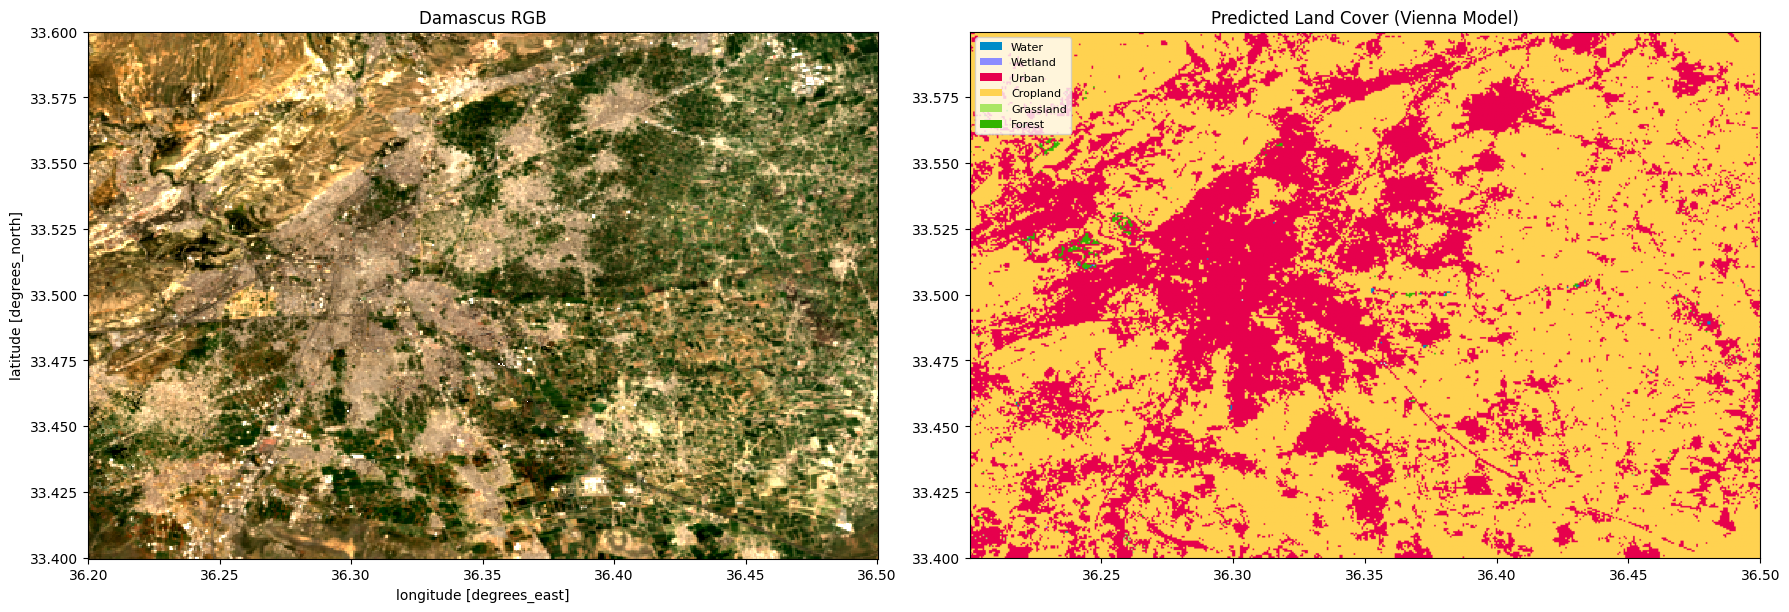

In [85]:
# Apply Vienna model to Damascus
image_data_dam = all_median_dam.to_array(dim="band").transpose(
    "latitude", "longitude", "band"
)

img_shape_dam = (all_median_dam.sizes["latitude"], all_median_dam.sizes["longitude"])
X_image_dam = image_data_dam.values.reshape(-1, len(FEATURE_BANDS))

nan_mask_dam = np.isnan(X_image_dam).any(axis=1)
X_image_dam_clean = np.nan_to_num(X_image_dam)
X_image_dam_scaled = scaler_final.transform(X_image_dam_clean)

y_pred_dam = rf_final.predict(X_image_dam_scaled).reshape(img_shape_dam).astype(float)
y_pred_dam[nan_mask_dam.reshape(img_shape_dam)] = np.nan

fig_dam, axes_dam = plt.subplots(1, 2, figsize=(18, 8))

rgb_damascus.plot.imshow(ax=axes_dam[0], robust=True)
axes_dam[0].set_title("Damascus RGB")
axes_dam[0].set_aspect("equal")

axes_dam[1].imshow(
    y_pred_dam,
    cmap=cmap,
    norm=norm,
    extent=[
        all_median_dam.longitude.min(),
        all_median_dam.longitude.max(),
        all_median_dam.latitude.min(),
        all_median_dam.latitude.max(),
    ],
)
axes_dam[1].set_title("Predicted Land Cover (Vienna Model)")
axes_dam[1].set_aspect("equal")
axes_dam[1].legend(patches, labels, loc="upper left", fontsize=8)
plt.tight_layout()